In [5]:
import geopandas as gpd
import pandas as pd
from psycopg2.pool import SimpleConnectionPool
import numpy as np
import datetime
# import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [6]:
gdf = gpd.read_file('data/samara_for_predict_2023.json')
gdf

ImportError: The 'read_file' function requires the 'pyogrio' or 'fiona' package, but neither is installed or imports correctly.
Importing fiona resulted in: DLL load failed while importing _env: Не найдена указанная процедура.
Importing pyogrio resulted in: DLL load failed while importing _ogr: Не найдена указанная процедура.

In [4]:
from shapely.geometry import shape
from shapely.validation import make_valid

def __process_geometry__(geom) -> str:
    """
    Обрабатывает геометрию для формирования корректного WKT.

    :param geom: Геометрия объекта.
    :return (str): Обработанная геометрия в формате WKT.
    """
    valid_geom = make_valid(geom)
    simplified_geom = valid_geom.simplify(
        tolerance=100, preserve_topology=True)
    buffered_geom = simplified_geom.buffer(0.01)
    buffered_wkt = buffered_geom.wkt
    if len(buffered_wkt) > 1000:
        envelope_geom = valid_geom.envelope
        return envelope_geom.wkt
    else:
        return buffered_wkt
    
__process_geometry__(shape(gdf[0]['geometry']))    

In [6]:
db_config = {
    'dbname': 'geoservice',
    'user': 'postgres',
    'password': 'qypTBq2aVV4',
    'host': 'localhost',
    'port': '5432'
}

YEAR = 2023

request_string = '''SELECT "AgroFieldID", "NDVI", "Date" FROM geoservice.agrofieldndvi WHERE EXTRACT(YEAR FROM "Date") = %s;'''

In [7]:
conn_pool = SimpleConnectionPool(1, 5, **db_config)
try:
    conn = conn_pool.getconn()
    cursor = conn.cursor()
    try:
        cursor.execute(request_string, (YEAR,))
        dfSeries = pd.DataFrame(cursor.fetchall(), columns=['ID', 'NDVI', 'Date'])
        # cursor.execute("DELETE FROM geoservice.agrofieldndvi;")
    finally:
        cursor.close()
        conn_pool.putconn(conn)
except Exception as e:
    print(f"Error {e} occured")

dfSeries = dfSeries.dropna()
dfSeries

,ID,NDVI,Date
0,0,0.534243,2023-09-01
1,0,0.492555,2023-08-20
2,0,0.501191,2023-08-17
3,0,0.530222,2023-08-07
4,0,0.518367,2023-08-05
...,...,...,...
497217,4532,0.298207,2023-08-15
497218,4532,0.635152,2023-08-05
497219,4532,0.653918,2023-07-26
497220,4532,0.640098,2023-07-14


In [11]:
from scipy.interpolate import InterpolatedUnivariateSpline

veg_start_date = datetime.date(YEAR, 4, 1).toordinal()  # c 01-04 по 01-09
veg_end_date = datetime.date(YEAR, 9, 1).toordinal()
veg_dates = [(datetime.date.fromordinal(date))
             for date in np.arange(veg_start_date, veg_end_date)]
features = []
labels = []
objIDs = []

for key in dfSeries['ID'].unique():
    X = np.array(dfSeries.loc[dfSeries['ID'] == key, 'Date']).flatten()
    Y = np.array(dfSeries.loc[dfSeries['ID'] == key, 'NDVI'])
    X_ordinals = np.array([i.toordinal() for i in X[::-1]])
    Y = np.array([i for i in Y[::-1]])

    # newX = np.arange(veg_start_date, veg_end_date)
    # newY = np.interp(newX, X_ordinals, Y)

    if Y[0] < 0:
        X_ordinals[0] = veg_start_date
        Y[0] = 0

    for i in range(1, len(Y) - 1):
        if Y[i-1] > 0 and Y[i] < 0 and Y[i+1] > 0:
            Y[i] = np.mean((Y[i-1], Y[i+1]))

    
    X_ordinals = X_ordinals - veg_start_date
    sorted_indices = np.argsort(X_ordinals)
    X_ordinals = X_ordinals[sorted_indices]
    Y = Y[sorted_indices]
    if X_ordinals[0] > 15:
        X_ordinals = np.insert(X_ordinals, 0, 0)
        Y = np.insert(Y, 0, 0)
    newX = np.arange(veg_end_date - veg_start_date)
    try:
        s = InterpolatedUnivariateSpline(X_ordinals, Y, k=1)
        newY = s(newX)
    except Exception as e:
        break

    features.append(newY)
    objIDs.append(key)
    labels.append(str(gdf.loc[(gdf['ID'] == key), 'CropClass'].values).translate({ord(i): None for i in '\'[]'}))

features = np.array(features, dtype="float")
labels = np.array(labels)

In [13]:
features[123, ], features.shape

(array([0.        , 0.00897031, 0.01794061, 0.02691092, 0.03588122,
        0.04485153, 0.05382184, 0.06279214, 0.07176245, 0.08073276,
        0.08970306, 0.09867337, 0.10764367, 0.11661398, 0.12558429,
        0.13455459, 0.1435249 , 0.15249521, 0.16146551, 0.17043582,
        0.17940612, 0.18837643, 0.19734674, 0.20631704, 0.23634688,
        0.26637672, 0.29640656, 0.3264364 , 0.35646625, 0.36117922,
        0.3658922 , 0.37060517, 0.37531814, 0.38003112, 0.38474409,
        0.38945707, 0.39417004, 0.39888302, 0.40359599, 0.40830897,
        0.41302194, 0.41773492, 0.42244789, 0.42716087, 0.43187384,
        0.43658682, 0.44739514, 0.45820347, 0.46901179, 0.46623372,
        0.46345565, 0.46471716, 0.46597868, 0.46724019, 0.46716229,
        0.46708438, 0.46700647, 0.46692857, 0.46685066, 0.46677275,
        0.46669484, 0.46661694, 0.46653903, 0.46646112, 0.46293206,
        0.45940299, 0.45587392, 0.45234485, 0.44881578, 0.44528672,
        0.44175765, 0.43822858, 0.43469951, 0.43

In [14]:
labels.shape

(32317,)

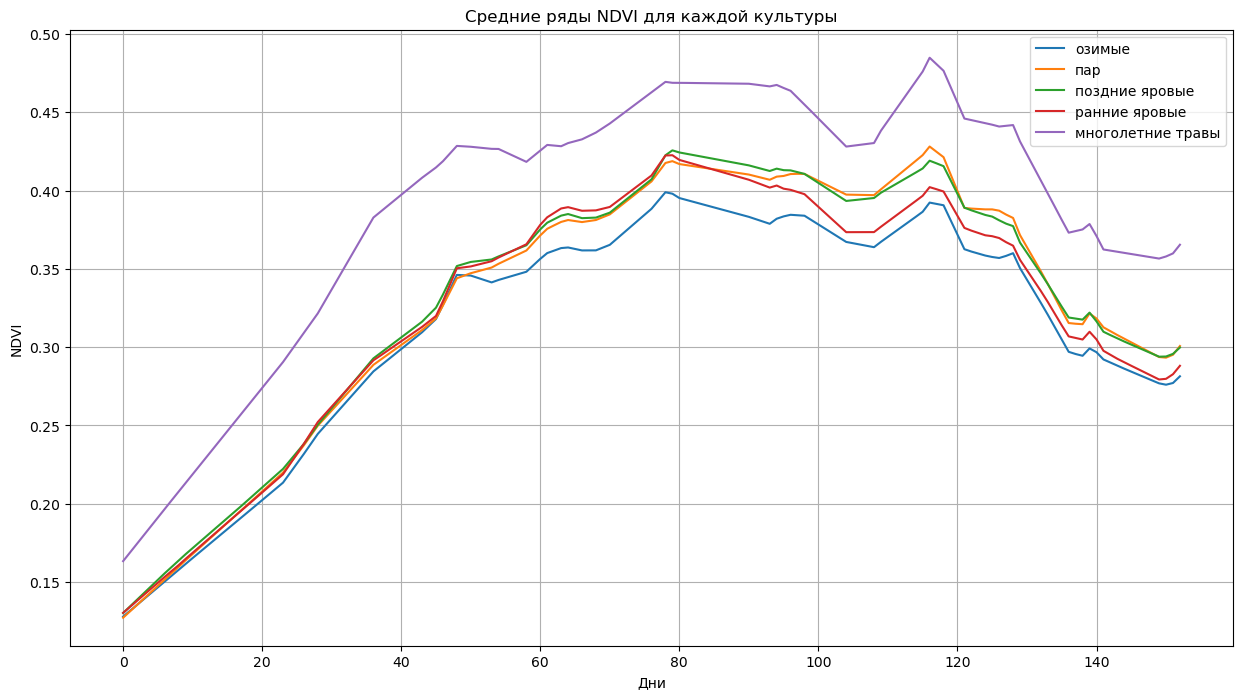

In [15]:
from collections import defaultdict

culture_ndvi = defaultdict(list)
for feature, label in zip(features, labels):
    culture_ndvi[label].append(feature)

average_ndvi = {}
for culture, ndvi_series in culture_ndvi.items():
    average_ndvi[culture] = np.mean(ndvi_series, axis=0)

plt.figure(figsize=(15, 8))
for culture, avg_ndvi in average_ndvi.items():
    plt.plot(avg_ndvi, label=culture)

plt.title('Средние ряды NDVI для каждой культуры')
plt.xlabel('Дни')
plt.ylabel('NDVI')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [16]:
# for i in range(0, 30):
#     plt.figure(figsize=(6, 3))
#     plt.plot(veg_dates, features[i], label='Интерполяция NDVI')
#     plt.scatter(dfSeries.loc[dfSeries['ID'] == objIDs[i], 'Date'], dfSeries.loc[dfSeries['ID']
#                 == objIDs[i], 'NDVI'], color='red', label='Исходные NDVI')
#     plt.xlabel('Дата')
#     plt.ylabel('NDVI')
#     plt.title(f'Интерполяция NDVI для ID {key}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [18]:
def create_split(random_state):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=random_state*17)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [19]:
# accuracy = []
# ins = range(10, 300, 5)
# for i in ins:
#     X_train, X_test, y_train, y_test = create_split(17)
#     gnb = RandomForestClassifier(max_depth=13, n_estimators=i)
#     model = gnb.fit(X_train, y_train)
#     preds = gnb.predict(X_test)
#     accuracy.append(accuracy_score(y_test, preds))

# indx = np.argmax(accuracy)
# print(accuracy[indx])

# plt.plot(ins, accuracy)
# plt.xlabel('Количество деревьев')
# plt.ylabel('Точность')
# plt.title('Зависимость точности от кол. деревьев при неизменной глубине деревьев')
# plt.show()

In [20]:
# accuracy = []
# ins = range(1, 30)
# for i in ins:
#     X_train, X_test, y_train, y_test = create_split(17)
#     gnb = RandomForestClassifier(max_depth=i, n_estimators=143)
#     model = gnb.fit(X_train, y_train)
#     preds = gnb.predict(X_test)
#     accuracy.append(accuracy_score(y_test, preds))

# indx = np.argmax(accuracy)
# print(accuracy[indx])

# plt.plot(ins, accuracy)
# plt.xlabel('Глубина')
# plt.ylabel('Точность')
# plt.title('Зависимость точности от глубины деревьев при неизменном кол. деревьев')
# plt.show()

In [21]:
KFold = 10

trains = []
accuracys = np.zeros((KFold, 1), dtype='float32')
label_encoder = LabelEncoder()

for i in range(KFold):
    X_train, X_test, y_train, y_test = create_split(i)
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    rfc = RandomForestClassifier(
        max_depth=13, n_estimators=143, random_state=i)
    rfc.fit(X_train, y_train_encoded)
    preds = rfc.predict(X_test)
    preds_original = label_encoder.inverse_transform(preds)
    accuracy = accuracy_score(y_test_encoded, preds)
    accuracys[i] = accuracy
    trains.append((X_train, y_train))

indx = np.argmax(accuracys)
print(accuracys, '\n')
model = rfc.fit(trains[indx][0], trains[indx][1])
print(accuracys[indx])

[[0.42747524]
 [0.41955444]
 [0.42029703]
 [0.42747524]
 [0.42871287]
 [0.42920792]
 [0.41831684]
 [0.4240099 ]
 [0.41423267]
 [0.4190594 ]] 

[0.42920792]


In [22]:
# import joblib
# model_path = f"models/model_{datetime.datetime.now().date()}_{datetime.datetime.now().toordinal()}.joblib"
# joblib.dump(model, model_path, compress=9)
# model1 = joblib.load(model_path)
# _, _, xt, yt = create_split(3)
# pred = model1.predict(xt)
# accuracy_score(yt, pred)
# model_path